<center><h1>PCA</h1></center>

In this assignment we have to fullfill the following tasks:

Create labeled surrogate data sets. Perform a PCA/Class prediction with ovr logistic regression analysis as developed in the lecture.

* **a:** 4 blobs: Create clearly separable 4-blobs in 3d but also a ’disaster’ realization with strong overlaps. Study, show and compare elbow plots and prediction boundaries.

* **b:** 2 touching parabola spreads as shown in the lecture, but in 3d (not 2d). Study and show elbow plot and prediction boundaries.

**Note:** Every plot must be followed by a small take home message.

In [96]:
### imports ###
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

<div class="alert alert-block alert-info">
<b>Note:</b> In order to present the different changes, if we go from clearly separable to unclear and unseparable, we will use the prefix <i>cs_</i> for clearly separable and <i>uc_</i> for unclear separable.
</div>

In [364]:
class Blobs_and_parabolas():
    
    def __init__(self, n_samples = 250, n_features = 13, centers = 4, cluster_std = 1, center_box =(-50,50),
                blob = None, parabola = None):
        if blob:
            self.X, self.y = make_blobs(n_samples = n_samples,
                                        n_features = n_features,
                                        centers = centers,
                                        cluster_std = cluster_std,
                                        center_box = center_box)
        elif parabola:
            self.X, self.y = make_moons(n_samples = 10000)
            for i in range(0,n_features):
                self.X = np.column_stack((self.X, np.random.choice(self.X[:,1], len(self.X)).T))
            self.idx = self.y == 1
        else:
            assert("Please select either blob = True or parabola = True")
            
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
                                self.X, self.y, test_size=0.3, stratify=self.y, random_state=0)
        # Standardize the features (zero mean, unit variance) 
        self.sc = StandardScaler()
        # Fit results must be used later (mu and sigma)
        self.X_train_std = self.sc.fit_transform(self.X_train)
        # Normalize test data set with mu/sigma of training data
        self.X_test_std = self.sc.transform(self.X_test)
        self.cov_mat = np.cov(self.X_train_std.T) #cov matrix from data
        self.EVal, self.EVec = np.linalg.eig(self.cov_mat)
        self.sum_EVal = sum(self.EVal)
        self.var_exp = [(i / self.sum_EVal) for i in sorted(self.EVal, reverse=True)]
        
    def _pca_and_lr(self, n_components = 2):
        # Set up PCA and logistic regression model
        self.pca = PCA(n_components= n_components)
        self.lr = LogisticRegression(multi_class='ovr', solver='liblinear')

        # Fit and transform training data, given on PCA reduction to k(=2) principle components
        self.X_train_pca = self.pca.fit_transform(self.X_train_std)
        self.X_test_pca = self.pca.transform(self.X_test_std)
        # solves task, given 3 classes (as from y_train) 
        self.lr.fit(self.X_train_pca, self.y_train)
        
    def plot_decision_regions(self, resolution=0.01, subplot = False):
        self._pca_and_lr()
        # Does not work....always....Setup marker generator and color map: FIXED!
        colors = ('r', 'b', 'g', "y")
        markers = ('s', 'v', 'o', 'p') 
        cmap = ListedColormap(colors[:len(np.unique(self.y_train))])

        # plot the decision surface
        x1_min, x1_max = self.X_train_pca[:, 0].min() - 1, self.X_train_pca[:, 0].max() + 1
        x2_min, x2_max = self.X_train_pca[:, 1].min() - 1, self.X_train_pca[:, 1].max() + 1
        xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                               np.arange(x2_min, x2_max, resolution))

        # Z is the prediction of the class, given point in plane
        Z = self.lr.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
        Z = Z.reshape(xx1.shape)

        # Z=f(xx1,yy1), plot classes in plane using color map but opaque
        plt.contourf(xx1, xx2, Z, alpha=0.2, cmap=cmap)
        plt.xlim(xx1.min(), xx1.max())
        plt.ylim(xx2.min(), xx2.max())

        # Plot data points, given labels
        for idx, cl in enumerate(np.unique(self.y_train)):
            plt.scatter(x=self.X_train_pca[self.y_train == cl, 0], 
                        y=self.X_train_pca[self.y_train == cl, 1],
                        alpha=0.6, 
                        c=[cmap(idx)],
                        edgecolor='black',
                        marker=markers[idx], 
                        label=cl)
#         plt.show()

In [365]:
cs = Blobs_and_parabolas(blob = True)
uc = Blobs_and_parabolas(blob = True, cluster_std = 30)

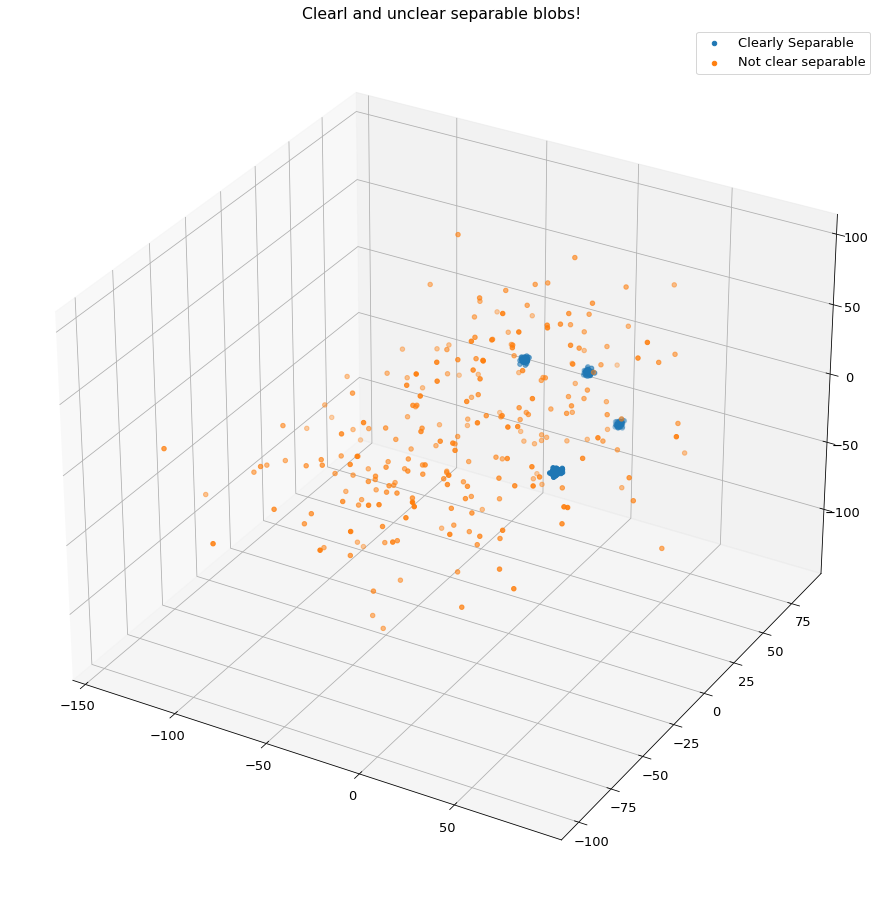

In [366]:
fig = plt.figure(figsize = (16,16))
  
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
plt.rcParams['font.size'] = '13'
ax.scatter3D(cs.X[:, 0], cs.X[:, 1], cs.X[:, 2], label = "Clearly Separable")
ax.scatter3D(uc.X[:, 0], uc.X[:, 1], uc.X[:, 2], label= "Not clear separable")
ax.legend()
plt.title("Clearl and unclear separable blobs!")
plt.show()

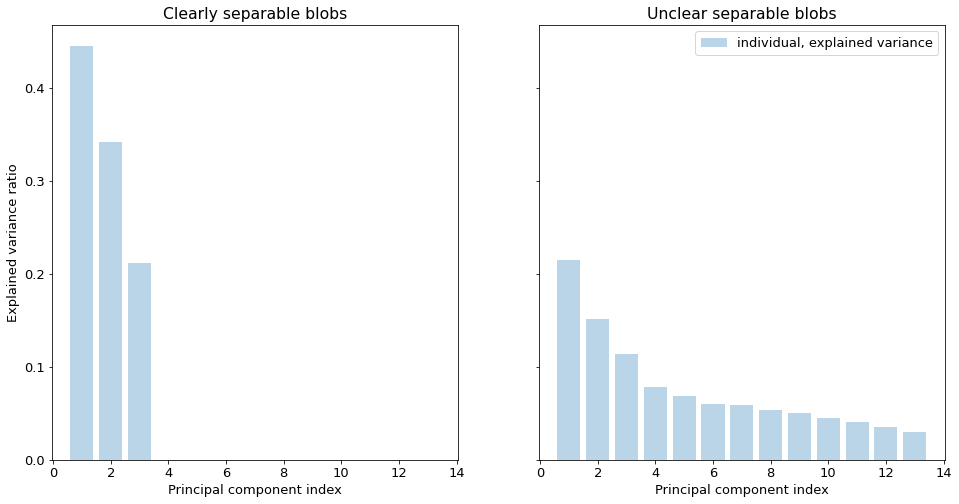

In [367]:
# Plot explained variances
fig, ax = plt.subplots(1,2, figsize = (16,8), sharey = True)
ax[0].bar(range(1,14), cs.var_exp, alpha=0.3, 
        align='center', label='individual, explained variance')
ax[0].set_ylabel('Explained variance ratio')
ax[0].set_xlabel('Principal component index')
ax[0].set_title("Clearly separable blobs")
ax[1].bar(range(1,14), uc.var_exp, alpha=0.3, 
        align='center', label='individual, explained variance')
ax[1].set_xlabel('Principal component index')
ax[1].set_title("Unclear separable blobs")
plt.legend(loc='best')
plt.show()

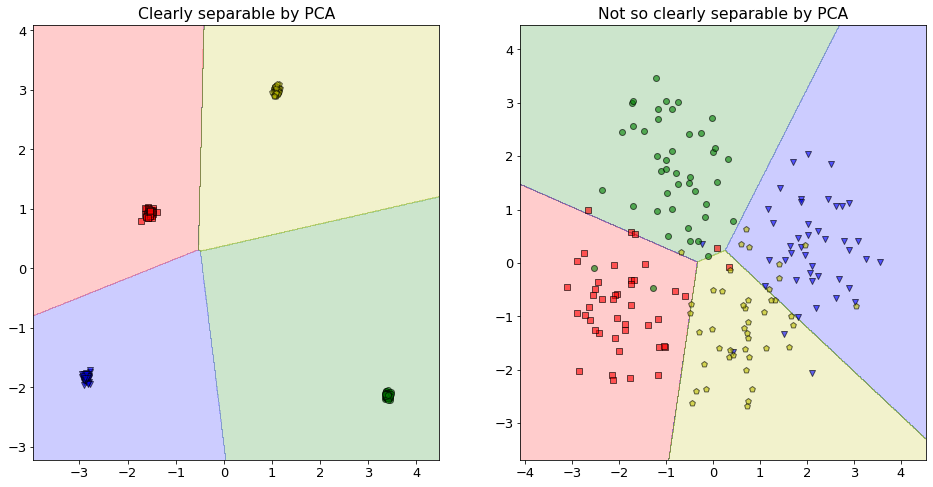

In [368]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
cs.plot_decision_regions()
plt.title("Clearly separable by PCA")

plt.subplot(122)
uc.plot_decision_regions()
plt.title("Not so clearly separable by PCA")
plt.show()

## Question 2:a

Under the current parameters, there is a clear separation between classes zero and one, but classes two and three represent a disaster realization and hence overlap significantly. 

<b>To Do</b>
- Subject to your guys' thoughts I'd say let's create a bunch of different plots showing how the class separation looks when we using different decision boundaries, and then just provide a few sentences summarizing what these plots show. 
- Also I think he wants at least one of the plots to contain classes that are all clearly separable.
- I think he also wants us to show the corresponding elbow histograms for each blob plot made. 

<b>Questions for Group</b> <br>
1) Are you guys clear on what Nagler means by a "disaster realization"? <br>
2) He asks us to show the elbow plots as well as the prediction boundary. Does he mean a decision boundary rather than a prediction boundary? I'm not really sure what a prediction boundary would be. 

## Question 2:b
In the parabola spread visualizations shown above, one can see how the data on the sides of each parabola is easily identified as being part of one class or the other. That is not the case for the data points near each vertex, as the vertices get quite close to each another and actually touch at one point. <br>
<b>So what? What is the takeway?</b>



<b>Questions</b><br>
1) So to confirm, the parabola spreads are another way of classifying the blobs right?
2) Perhaps the approach we take here is similar to what we do in 2a, just here the visualization are the 3d parabolic spreads?

In [376]:
cs = Blobs_and_parabolas(parabola = True, n_features = 1)
uc = Blobs_and_parabolas(parabola = True)

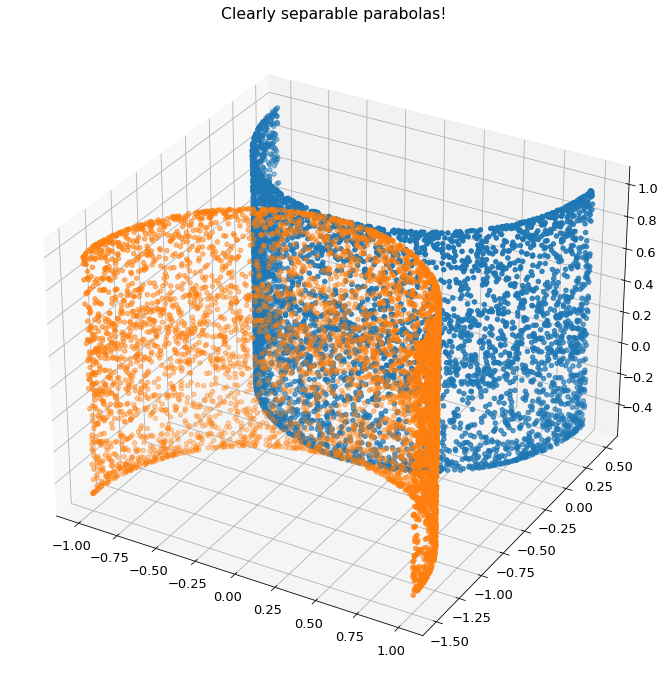

In [377]:
fig = plt.figure(figsize = (12,12))
  
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
ax.scatter3D(cs.X[cs.idx, 0]-1, cs.X[cs.idx, 1], cs.X[cs.idx, 2])
ax.scatter3D(uc.X[~uc.idx, 0], uc.X[~uc.idx, 1]-1.5, uc.X[~uc.idx, 2])
plt.title("Clearly separable parabolas!")
plt.show()

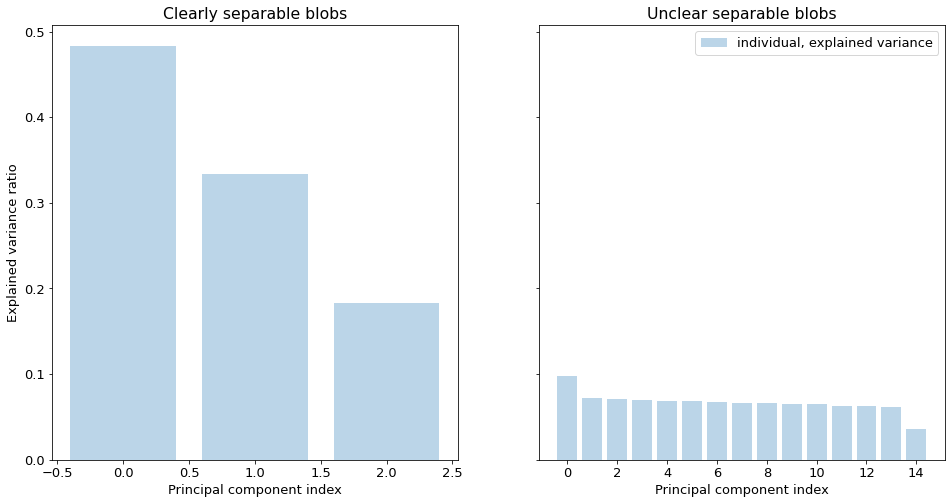

In [380]:
# Plot explained variances
fig, ax = plt.subplots(1,2, figsize = (16,8), sharey = True)
ax[0].bar(range(0,3), cs.var_exp, alpha=0.3, 
        align='center', label='individual, explained variance')
ax[0].set_ylabel('Explained variance ratio')
ax[0].set_xlabel('Principal component index')
ax[0].set_title("Clearly separable blobs")
ax[1].bar(range(0,15), uc.var_exp, alpha=0.3, 
        align='center', label='individual, explained variance')
ax[1].set_xlabel('Principal component index')
ax[1].set_title("Unclear separable blobs")
plt.legend(loc='best')
plt.show()

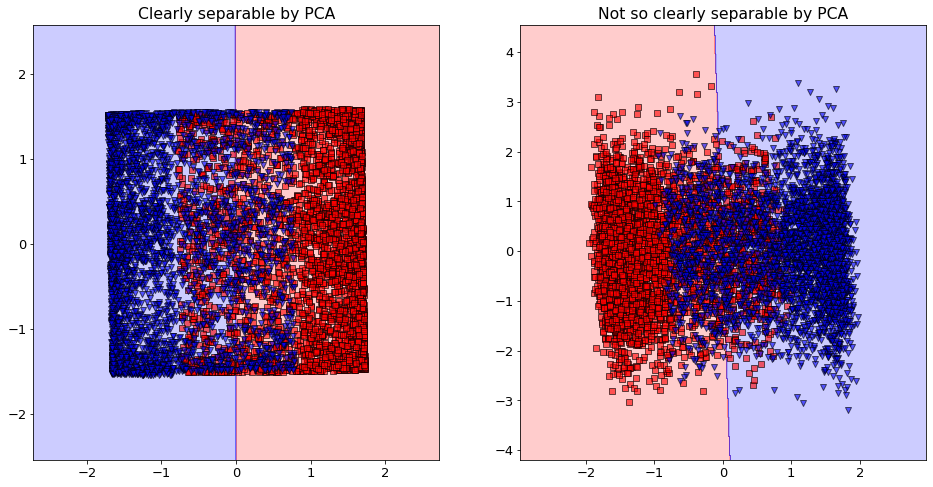

In [381]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
cs.plot_decision_regions()
plt.title("Clearly separable by PCA")

plt.subplot(122)
uc.plot_decision_regions()
plt.title("Not so clearly separable by PCA")
plt.show()